In [ ]:
import numpy as np
import os
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.utils import save_image


In [ ]:

#连接谷歌硬盘
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import cv2

class DeepLabSegmentationTool:
    def __init__(self):
        # Load the pre-trained DeepLabV3 model
        self.model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()
        self.preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def get_deeplab_segmentation(self, image_path):
        # Load and enhance the image to improve segmentation
        image = Image.open(image_path).convert("RGB")
        image = ImageEnhance.Contrast(image).enhance(1.5)  # Increase contrast
        image = ImageEnhance.Brightness(image).enhance(1.2)  # Increase brightness
        input_tensor = self.preprocess(image).unsqueeze(0)

        # Perform segmentation
        with torch.no_grad():
            output = self.model(input_tensor)['out']

        # Get the segmentation mask (the class index with the highest score for each pixel)
        segmentation_mask = output.argmax(1).squeeze().cpu().numpy()

        # Apply a threshold to ensure we keep enough of the foreground
        unique_values, counts = np.unique(segmentation_mask, return_counts=True)
        if counts[0] / np.sum(counts) > 0.8:  # If more than 80% is background
            # Assume segmentation is poor, try to preserve more of the original image
            segmentation_mask[segmentation_mask == 0] = 1  # Set background to foreground

        return segmentation_mask

    def apply_segmentation_mask(self, image_path, mask):
        # Load the original image
        image = Image.open(image_path).convert("RGB")
        image = image.resize((224, 224))
        image_np = np.array(image)

        # Apply morphology to refine the mask
        kernel = np.ones((5, 5), np.uint8)
        refined_mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)

        # Create a mask where the background is set to 0 (black)
        masked_image = np.where(refined_mask[:, :, None] == 0, 0, image_np)

        return masked_image

    def apply_mask_to_tensor(self, image_tensor, mask):
        # Ensure mask has the same size as image_tensor
        mask_tensor = torch.tensor(mask, device=image_tensor.device).unsqueeze(0).unsqueeze(0).float()  # 形状: [1, 1, H, W]
        mask_tensor = torch.nn.functional.interpolate(mask_tensor, size=image_tensor.shape[2:], mode='nearest')

        # 将 mask 应用于图像张量
        masked_image_tensor = image_tensor * mask_tensor
        return masked_image_tensor

    def visualize_segmentation(self, image_path, mask):
        masked_image = self.apply_segmentation_mask(image_path, mask)

        # Apply edge detection to enhance the mask visualization
        edges = cv2.Canny(mask.astype(np.uint8) * 255, 100, 200)

        # Plot the original image, mask, and masked image
        fig, ax = plt.subplots(1, 4, figsize=(24, 6))
        original_image = Image.open(image_path).resize((224, 224))
        ax[0].imshow(original_image)
        ax[0].set_title('Original Image')
        ax[0].axis('off')

        ax[1].imshow(mask, cmap='gray')
        ax[1].set_title('Segmentation Mask')
        ax[1].axis('off')

        ax[2].imshow(masked_image)
        ax[2].set_title('Masked Image')
        ax[2].axis('off')

        ax[3].imshow(edges, cmap='gray')
        ax[3].set_title('Edge Detection Overlay')
        ax[3].axis('off')

        plt.show()




In [ ]:
class ImageFeatureExtractor():
    def __init__(self, selected_layers=None, image_size=(224, 224)):
        super().__init__()
        self.features = models.vgg19(pretrained=True).features
        self.model = models.vgg19(pretrained=True).features
        self.classifier = models.vgg19(pretrained=True).classifier
        self.model = self.model.to(device)
        self.features = self.features.to(device) # Move features to the same device as the model
        self.classifier = self.classifier.to(device)
        for param in self.model.parameters():
            param.requires_grad = False
        self.model = self.model.to('cuda' if torch.cuda.is_available() else 'cpu')

        # 设置要提取的特征层
        self.selected_content_layers = [21]
        self.selected_style_layers = [0, 5, 10, 19,28]
        # 定义图片预处理流程
        self.preprocess = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])


    def load_and_preprocess_image(self, image_path):
        """加载并预处理图片"""
        image = Image.open(image_path).convert("RGB")
        image = self.preprocess(image)
        image = image.unsqueeze(0)  # 增加批量维度
        return image.to('cuda' if torch.cuda.is_available() else 'cpu')



    def extract_content_features(self, image_tensor):
        """从预处理后的图片中提取特征"""
        features = []
        x = image_tensor
        for name, layer in self.model._modules.items():
            x = layer(x)
            if name in self.selected_content_layers:
                features.append(x)
        return features

    def extract_style_features(self, image_tensor):
        """从预处理后的图片中提取特征"""
        features = []
        x = image_tensor
        for name, layer in self.model._modules.items():
            x = layer(x)
            if name in self.selected_style_layers:
                features.append(x)
        return features

    def extract_logits_features(self, image_tensor):
        #提取logits特征
        x = image_tensor
        for layer in self.features:
            x = layer(x)

        # 展平成适合输入到全连接层的形状
        x = x.view(x.size(0), -1)
        # 通过分类器部分 (classifier)
        for layer in self.classifier:
            x = layer(x)
        # 返回最终的 logits
        return x


    @staticmethod
    def gram_matrix(feature):
        """计算给定特征的Gram矩阵"""
        batch_size, num_channels, height, width = feature.size()
        features = feature.view(batch_size * num_channels, height * width)
        G = torch.mm(features, features.t())
        return G / (batch_size * num_channels * height * width)

    def get_gram_matrices(self, image_tensor):
        features = self.extract_style_features(image_tensor)
        gram_matrices = [self.gram_matrix(feature) for feature in features]
        return gram_matrices








In [ ]:
def style_loss(adversarial_image_tensor, style_image_tensor):
    """
    计算两张图像的风格损失。
    """
    # 实例化特征提取器
    feature_extractor = ImageFeatureExtractor()

    # 获取两张图像的 Gram 矩阵
    gram_matrices_1 = feature_extractor.get_gram_matrices(adversarial_image_tensor)
    gram_matrices_2 = feature_extractor.get_gram_matrices(style_image_tensor)

    # 计算风格损失
    loss = 0
    for i in range(len(gram_matrices_1)):
        loss += torch.mean((gram_matrices_1[i] - gram_matrices_2[i]) ** 2)

    return loss



In [ ]:
def content_loss(adversarial_image_tensor, original_image_tensor):
    """
    计算两张图像的内容损失。
    """

    # 实例化特征提取器
    feature_extractor = ImageFeatureExtractor()

    # 提取两张图像的特征
    features_adversarial = feature_extractor.extract_content_features(adversarial_image_tensor)
    features_original = feature_extractor.extract_content_features(original_image_tensor)

    # 计算内容损失
    loss = 0
    for i in range(len(features_adversarial)):
        loss += torch.mean((features_adversarial[i] - features_original[i]) ** 2)

    return loss




In [ ]:
def adversarial_loss(adversarial_image_tensor, original_class, desired_target_class, balance=5):
    #实例化
    features_extractor= ImageFeatureExtractor()
    adversarial_logits=features_extractor.extract_logits_features(adversarial_image_tensor)

    #计算目标损失
    target_class = torch.tensor([desired_target_class]).to(adversarial_logits.device)
    target_loss = F.cross_entropy(adversarial_logits, target_class)
    #计算原始图像损失
    avoid_class_probs = F.softmax(adversarial_logits, dim=1)[:, original_class]
    avoid_loss = -torch.log(1 - avoid_class_probs + 1e-6)

    # 计算对抗损失
    loss_attack = balance * target_loss + avoid_loss.mean()
    return loss_attack



In [ ]:
def total_loss(adversarial_image_tensor,
               original_image_tensor,style_image_tensor,original_class, desired_target_class,
               lambda_adv, alpha, beta):


    # 计算各项损失
    adv_loss = adversarial_loss(adversarial_image_tensor, original_class, desired_target_class, balance=5)  # 对抗性损失
    style_loss_val = style_loss(adversarial_image_tensor, style_image_tensor)  # 风格损失
    content_loss_val = content_loss(adversarial_image_tensor, original_image_tensor)  # 内容损失

    # 组合总损失
    total_loss_val = lambda_adv * adv_loss + alpha * style_loss_val + beta * content_loss_val
    return total_loss_val


In [ ]:
def generate_adversarial_image(original_image_path, style_image_path,
                               original_class, desired_target_class,
                               lambda_adv, alpha, beta, num_steps, lr):
    #实例化
    feature_extractor = ImageFeatureExtractor()
    segment_extractor = DeepLabSegmentationTool()
    #提取mask
    mask_original = segment_extractor.get_deeplab_segmentation(original_image_path)

    #提取张量
    original_image_tensor = feature_extractor.load_and_preprocess_image(original_image_path)
    style_image_tensor = feature_extractor.load_and_preprocess_image(style_image_path)

    #mask 覆盖
    adversarial_image_tensor = segment_extractor.apply_mask_to_tensor(original_image_tensor, mask_original)
    mask_original_tensor = segment_extractor.apply_mask_to_tensor(original_image_tensor, mask_original)

    #初始化对抗图片
    # noise = torch.randn_like(original_image_tensor) * 0.1
    # adversarial_image_tensor = mask_original_tensor + noise
    # adversarial_image_tensor = torch.clamp(adversarial_image_tensor, 0, 1)
    adversarial_image_tensor.requires_grad = True

    optimizer = optim.Adam([adversarial_image_tensor], lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
    #确保每个张量都在同一个设备上计算
    original_image_tensor = original_image_tensor.to(device)
    mask_original_tensor = mask_original_tensor.to(device)
    style_image_tensor = style_image_tensor.to(device)
    adversarial_image_tensor = adversarial_image_tensor.to(device)

    for step in range(num_steps):
        optimizer.zero_grad()

        loss = total_loss(adversarial_image_tensor,
               mask_original_tensor,style_image_tensor,original_class, desired_target_class,
               lambda_adv, alpha, beta)

        loss.backward()
        optimizer.step()
        scheduler.step()  # 更新学习率

        if step % 5 == 0:
            print(f"Step {step}, Loss: {loss.item()}")

    return adversarial_image_tensor


In [ ]:
  # 设置图像路径和参数
  original_image_path = "/content/drive/MyDrive/AD_Ori/n04090263_2335.JPEG"
  style_image_path = "/content/drive/MyDrive/Adversarial Camouflage: Hiding Physical-World Attacks with Natural Styles/Pikachu.jpg"
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  #设置对抗目标和原始图像索引
  desired_target_class = 546
  original_class = 764


  # 生成对抗性图像
  adversarial_image = generate_adversarial_image(
      original_image_path, style_image_path,
      original_class, desired_target_class,
      lambda_adv=40000, alpha=10, beta=100, num_steps=100, lr=0.01
  )





















Step 0, Loss: 2728732.5
Step 5, Loss: 52629.21484375
Step 10, Loss: 4820.51806640625
Step 15, Loss: 1356.1129150390625
Step 20, Loss: 5870.92041015625
Step 25, Loss: 276.310791015625
Step 30, Loss: 84.07731628417969
Step 35, Loss: 104.31214904785156
Step 40, Loss: 671.3325805664062
Step 45, Loss: 42.21472930908203
Step 50, Loss: 381.8682861328125
Step 55, Loss: 1335.3580322265625
Step 60, Loss: 145.9425811767578
Step 65, Loss: 84.22525787353516
Step 70, Loss: 46.01425552368164
Step 75, Loss: 599.1025390625
Step 80, Loss: 297.3920593261719
Step 85, Loss: 9.455455780029297
Step 90, Loss: 47.036922454833984
Step 95, Loss: 12.502279281616211


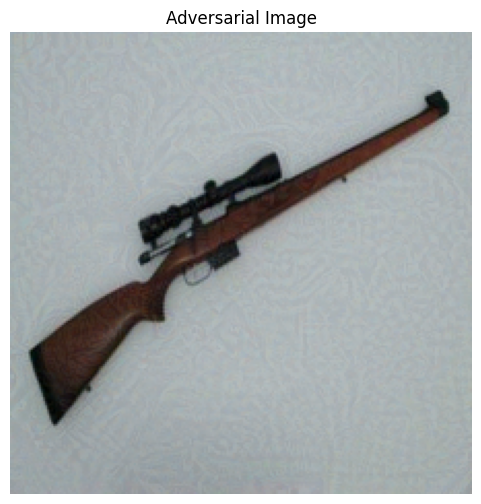

In [ ]:
class AdversarialImageProcessor:
    def __init__(self, mean=None, std=None):
        if mean is None:
            mean = [0.485, 0.456, 0.406]
        if std is None:
            std = [0.229, 0.224, 0.225]

        self.mean = mean
        self.std = std
        self.denormalize = self.Denormalize(mean=self.mean, std=self.std)
        self.unloader = transforms.Compose([
            self.denormalize,
            transforms.ToPILImage()
        ])

    class Denormalize(object):
        def __init__(self, mean, std):
            self.mean = mean
            self.std = std

        def __call__(self, tensor):
            # Create a copy of the tensor to avoid in-place modification
            tensor = tensor.clone()

            # 对每个通道反归一化：乘以标准差并加上均值, 使用out-of-place操作
            for i, (m, s) in enumerate(zip(self.mean, self.std)):
                tensor[i] = tensor[i].mul(s).add(m)  # t = t * s + m

            # 将张量值限制在 [0, 1] 范围内，防止超出可视化范围
            return torch.clamp(tensor, 0, 1)

    def remove_mask(self, adversarial_tensor, mask):
        # 将对抗性张量移动到 CPU 并去掉批量维度, 使用 detach()
        adversarial_np = adversarial_tensor.detach().squeeze().cpu().numpy()

        # 确保 mask 的大小与对抗性图像一致
        mask_resized = cv2.resize(mask, (adversarial_np.shape[1], adversarial_np.shape[2]))

        # 将 mask 应用于图像，去掉被 mask 遮盖的部分
        # 这里需要广播，保持三个通道一致
        masked_np = adversarial_np * mask_resized

        # 将处理后的 numpy 数组转换回 Tensor
        masked_tensor = torch.tensor(masked_np).unsqueeze(0)

        return masked_tensor.to(adversarial_tensor.device)

    def visualize_and_save_image(self, tensor, mask=None, filename='adversarial_image.png', show=True):

        # 将对抗样本张量从 GPU 移动到 CPU 并去掉批量维度
        tensor = tensor.squeeze().cpu()
        # 进行反归一化并转换为 PIL 图像
        image = self.unloader(tensor)
        # 保存图像到文件
        image.save(filename)

        # 显示图像和掩码
        if show:
            if mask is not None:
                #  如果提供了掩码，则显示两张图片：对抗样本和掩码
                fig, axes = plt.subplots(1, 2, figsize=(12, 6))

                # 显示去掉 mask 后的图像
                axes[0].imshow(np.array(image))
                axes[0].set_title('Adversarial Image Without Mask')
                axes[0].axis('off')

                # 显示 mask 图像
                axes[1].imshow(mask, cmap='gray')
                axes[1].set_title('Segmentation Mask')
                axes[1].axis('off')

            else:
                # 如果没有提供掩码，只显示对抗样本
                plt.figure(figsize=(6, 6))  # 设置图像大小
                plt.imshow(np.array(image))
                plt.title('Adversarial Image')
                plt.axis('off')

            plt.show()


processor = AdversarialImageProcessor()
segment_extractor = DeepLabSegmentationTool()
mask = segment_extractor.get_deeplab_segmentation(original_image_path)
# 移除 mask
unmasked_adversarial_image = processor.remove_mask(adversarial_image, mask)
# 可视化并保存移除 mask 后的图像
processor.visualize_and_save_image(unmasked_adversarial_image)

